---


**Датасет соревнования:** https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


**Описание:**

Toxic Comments

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.
<br><br>
**Цель:** Решить задачу бинарной классификации английских комментариев на токсичность (признак `toxic`)
<br><br>
**Задача:** Пробить минимальный порог по метрике
<br><br>
**Метрика:** F1-мера
<br><br>
**Порог по метрике:** Результаты дамми-модели
<br><br><br>
**UPD:** Сетка гиперпараметров урезана или отсутствует (не гарантируется, что выбранные гиперпараметры - лучшие). Всё сделано для того, чтобы всё запускалось быстро. Оставляю работу с гиперпараметрами заинтересованному читателю.

**UPD 2:** Некоторые предупреждения обработаны не были (напр.: связанные с параллелизмом huggingface и scikit-learn). Способ обработки зависит от целей читателя.

---

# <font color="RED">Caution!!!
</font>

<br>
<b>Датасет содержит нецензурную токсичную брань (подробнее в описании датасета на `kaggle`). Автор тетрадки не несет ответственности за содержание датасета и осуждает использование любых оскорблений в любой адрес.
<br><br>
Please be careful. The dataset contains offensive toxic language (for more information, see the description of the dataset on `kaggle`). The author of this notebook is not responsible for the content of the dataset and condemns the use of any insults to any people.

# Содержание:

1. [Работа с библиотеками](#c1)
2.  [Работа с датасетом](#c2)
  * [Загрузка датасета](#c3)
  * [Вводный анализ](#c4)
      * [Анализ датасета](#c5)
      * [Распределение в таргете](#c6)
      * [Анализ текстов](#c7)
  * [Предобработка данных](#c8)
      * [Выборки](#c9)
      * [Очистка](#c10)
      * [Спеллер](#c11)
      * [Лемматизация](#c12)
      * [Облако слов](#c13)
      * [LDA (Latent Dirichlet Allocation)](#c14)
  * [Получение признаков](#c15)
      * [TF-IDF](#c16)
      * [BERT](#c17)
  * [Борьба с дисбалансом в таргете](#c18)
  * [Вывод:](#c19)
3.  [Обучение моделей](#c20)
  * [На признаках TF-IDF](#c21)
      * [Обучение](#c21)
      * [Результат](#c23)
  * [На эмбеддингах BERT](#c24)
      * [Обучение](#c24)
      * [Результат](#c25)
  * [Тестирование](#c26)
  * [Вывод:](#c27)
4. [Немного про CatBoost и текстовые признаки](#c28)
5. [Финальный вывод:](#c29)

[**Bonus:** Tensorflow/Keras (Bidirectional LSTM)](#c30)

<a name="c1"></a>
# Работа с библиотеками

In [ ]:
!nvidia-smi

Fri Aug  5 13:27:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# last actual version (20.07.2022)

!pip install wordcloud
!pip install catboost
!pip install -U imbalanced-learn
!pip install lightgbm
!pip install optuna
!pip install gensim
!pip install transformers
!pip install pyLDAvis
!pip install TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 34.4 MB/s 
     |████████████████████████████████| 199 kB 73.5 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 31.2 MB/s 
     |████████████████████████████████| 209 kB 61.5 MB/s 
     |█████████████████

In [ ]:
# Работа с данными
import pandas as pd
import numpy as np

# Облако слов
from wordcloud import WordCloud

# Для LDA
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models

# Для создания выборок
from sklearn.model_selection import train_test_split

# Перемешать записи
from sklearn.utils import shuffle

# Pipeline для TfidfVectorizer + модели
from sklearn.pipeline import Pipeline

# Pipeline из imblearn
from imblearn.pipeline import make_pipeline

# Получение признаков TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Метрики
from sklearn.metrics import f1_score
import sklearn.metrics as metrics

# Модели
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
import lightgbm as lgb

# Кросс-валидация
from sklearn.model_selection import cross_validate

# Копия модели
from sklearn.base import clone

# Подбор гиперпараметров для моделей
from sklearn.model_selection import GridSearchCV
import optuna 

# Борьба с дисбалансом в таргете через upsampling (Adaptive Synthetic/RandomOverSampler)
from imblearn.over_sampling import ADASYN, RandomOverSampler

# Лемматизация и стоп-слова для TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Спеллер
from textblob import TextBlob

# Работа с BERT'ом
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Модель
from catboost import CatBoostClassifier

# Удобное отслеживание прогресса
from tqdm import tqdm, notebook

# Из базовой библиотеки python:
import sys
import os
import time
import re

# Собираем мусор
import gc

# Визуальная часть работы
import matplotlib.pyplot as plt

# Красивые bar'ы
from tqdm import tqdm

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Скачивание необходимых пакетов nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Константы:

In [ ]:
RANDOM_STATE = 12345
STOPWORDS = stopwords.words('english')
BERT_TOKEN = 'unitary/toxic-bert'
BERT_MODEL = 'unitary/toxic-bert'
BATCH_SIZE = 64
CV = 5
METRIC = 'f1'
VERBOSE = 100
N_CPU = -1
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

<a name="c2"></a>
# Работа с датасетом

<a name="c3"></a>
## Загрузка датасета

Будем считать, что ZIP-файл для работы был уже скачан **участником соревнования**.

Разархивируем файл:

In [ ]:
!mkdir datasets
!unzip jigsaw-toxic-comment-classification-challenge.zip -d datasets
!dir datasets

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: datasets/sample_submission.csv.zip  
  inflating: datasets/test.csv.zip   
  inflating: datasets/test_labels.csv.zip  
  inflating: datasets/train.csv.zip  
sample_submission.csv.zip  test.csv.zip  test_labels.csv.zip  train.csv.zip


Разархивируем train.csv.zip:



In [ ]:
!unzip datasets/train.csv.zip -d datasets

Archive:  datasets/train.csv.zip
  inflating: datasets/train.csv      


<a name="c4"></a>
## Вводный анализ

Посмотрим на train.csv, с которым и будем работать:

In [ ]:
path1 = "../input/traint/train.csv"
path2 = "/content/datasets/train.csv"

if os.path.exists(path1):
    data = pd.read_csv(path1)
elif os.path.exists(path2):
    data = pd.read_csv(path2)
else:
    print("We have a problem")

Оставим в качестве признаков только `toxic` (таргет) и `comment_text`

In [ ]:
data = data[['comment_text', 'toxic']]
data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<a name="c5"></a>
### Анализ датасета

У нас есть два признака: `comment_text` и `toxic`.
<br><br>
`comment_text` - комментарии, которые нужно классифицировать

`toxic` - целевой признак в бинарном формате

In [ ]:
data.sample(5)

,comment_text,toxic
84191,I've notified you again on your talk page.,0
55962,"""\n\n Population of Pakistan \nIts 172,800,000...",0
133925,Censorship\nI do not know of any Wiki rule or ...,0
102277,"Once again, you are taking this way too person...",0
55652,Thanks for the advice.,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  159571 non-null  object
 1   toxic         159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Пропусков нет

In [ ]:
display(data.duplicated().sum())
display(data['comment_text'].duplicated().sum())

0

0

Явных дубликатов тоже

<a name="c6"></a>
### Распределение в таргете

Посмотрим на `toxic`:

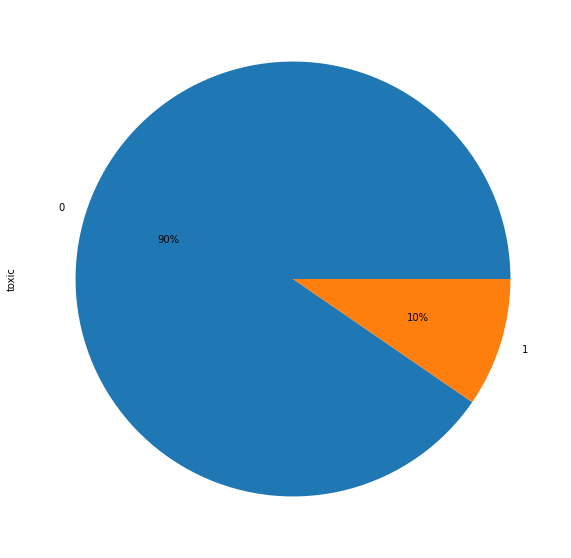

In [ ]:
data['toxic'].value_counts().plot(kind='pie', figsize=(10, 10), autopct='%1.0f%%')

`1 - toxic`<br><br> Явный дисбаланс в таргете. Учтем для дальнейшей работы

<a name="c7"></a>
### Анализ текстов

Посмотрим на уникальные символы в `comment_text`:

In [ ]:
unique_characters = []


def get_unique(text):
    global unique_characters
    unique_characters += list(text)


data['comment_text'].apply(get_unique)
unique_characters = set(unique_characters)

unique_characters = sorted(list(unique_characters))

# Взяли каждый 40-ый уникальный символ (10 символов)
print("Неинформативные символы:", *unique_characters[::40][:10])
print("Количество уникальных символов:", len(unique_characters))

Неинформативные символы: 
 G o ¯ × ÿ ħ Ŕ ż ɐ
Количество уникальных символов: 2335


В тексте есть множество неинформативных для нас символов (работаем только с английским языком)



In [ ]:
lenghts = data['comment_text'].apply(lambda x: len(x))
lenghts.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

Самые короткие комментарии:

In [ ]:
lenghts.loc[lenghts == 6]

52442     6
137062    6
Name: comment_text, dtype: int64

In [ ]:
data['comment_text'][52442]

'14:53,'

In [ ]:
data['comment_text'][137062]

'~ J.Lo'

Одни из самых длинных:

In [ ]:
lenghts.loc[lenghts == 5000].shape

(42,)

Максимум по длине во время сбора данных - это 5000? <br>С другой стороны, вышло мало записей максимальной длины

In [ ]:
lenghts.loc[lenghts == 5000].index[:5]

Int64Index([4174, 6201, 8705, 9673, 10769], dtype='int64')

In [ ]:
data['comment_text'][4174]

'ii CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARRES

In [ ]:
data['comment_text'][6201]

'SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYF

In [ ]:
# Статистика по токсичным комментариям (длина)

data['comment_text'].loc[data['toxic'] == 1].apply(lambda x: len(x)).describe()

count    15294.000000
mean       295.246044
std        617.379025
min          8.000000
25%         59.000000
50%        123.000000
75%        271.000000
max       5000.000000
Name: comment_text, dtype: float64

In [ ]:
# Статистика по нетоксичным комментариям (длина)

data['comment_text'].loc[data['toxic'] == 0].apply(lambda x: len(x)).describe()

count    144277.000000
mean        404.549339
std         586.850889
min           6.000000
25%         102.000000
50%         216.000000
75%         453.000000
max        5000.000000
Name: comment_text, dtype: float64

Комментарии можно попробовать ограничить по длине (перцентилями), но оставим датасет без фильтрации

<a name="c8"></a>

## Предобработка данных

<a name="c9"></a>

### Выборки

Для работы с BERT возьмем 4% (для ускорения вычислений) от выборки. <br>Разделим выборки соответствующим образом:

In [ ]:
data_tfidf, data_bert = train_test_split(data, test_size=.04, stratify=data['toxic'], random_state=RANDOM_STATE)

In [ ]:
print("Процент токсичных комментариев в: ")
print("Выборке для TF-IDF: ", round(data_tfidf['toxic'].mean() * 100, 2), '%', sep='')
print("Выборка для BERT: ", round(data_bert['toxic'].mean() * 100, 2), '%', sep='')

Процент токсичных комментариев в: 
Выборке для TF-IDF: 9.58%
Выборка для BERT: 9.59%


In [ ]:
print("Размер:")
print("Выборка для TF-IDF:", data_tfidf.shape[0])
print("Выборка для BERT:", data_bert.shape[0])

Размер:
Выборка для TF-IDF: 153188
Выборка для BERT: 6383


<a name="c10"></a>

### Очистка

Оставим символы только на английском языке для упрощения работы. <br>Зададим функцию `clear_text`:

In [ ]:
nan_value = float("NaN")


def clear_text(text: str) -> str:
    '''Очистка текста

    Parameters
    ----------
    text : str
        Комментарий из "comment_text"
    
    Returns
    -------
    str
        Очищенный текст / NaN
    '''
    cl_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())
    if len(cl_text) < 10:
        return nan_value
    return cl_text

Если в итоге получилась пустая строка длиной меньше 10, то вернём `NaN`

In [ ]:
data_tfidf['clear_text'] = data_tfidf['comment_text'].apply(clear_text)
data_bert['clear_text'] = data_bert['comment_text'].apply(clear_text)

In [ ]:
data_tfidf.isna().sum()

In [ ]:
data_bert.isna().sum()

Удалим `NaN`:

In [ ]:
data_tfidf.dropna(subset = ["clear_text"], inplace=True)
data_bert.dropna(subset = ["clear_text"], inplace=True)

<a name="c11"></a>
### Спеллер

Исправим опечатки в словах:

In [ ]:
def typos_words(text: str) -> str:
    '''Исправление очевидных опечаток

    Parameters
    ----------
    text : str
        Очищенный комментарий из "clear_text"
    
    Returns
    -------
    str
        Текст без опечаток
    '''
    text = TextBlob(text)
    return str(text.correct())

In [ ]:
typos_words('heklo ebrybody! hoq aee you?')

'hello everybody! how are you?'

In [ ]:
%%time

tqdm.pandas()

data_tfidf['clear_text'] = data_tfidf['clear_text'].progress_apply(typos_words)
data_bert['clear_text'] = data_bert['clear_text'].progress_apply(typos_words)

<a name="c12"></a>
### Лемматизация

*Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме*

Также перед тем, как получить признаки TF-IDF, лемматизируем слова в `data_tfidf` с помощью функции `lemmatize` и `WordNetLemmatizer` из `nltk`. Ещё есть `SpaCy`, но выберем классику

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text: str) -> str:
    '''Лемматизация слов

    Parameters
    ----------
    text : str
        Очищенный комментарий без опечаток из "clear_text"
    
    Returns
    -------
    str
        Текст с лемматизированными словами
    '''
    # Делим текст на токены
    word_list = nltk.word_tokenize(text)
    # Лемматизированные слова добавляем в лист
    lemmatized_output = [lemmatizer.lemmatize(w) for w in word_list]
    # Возвращаем текстом    
    return ' '.join(lemmatized_output)

In [ ]:
%%time

data_tfidf['lemm_text'] = data_tfidf['clear_text'].apply(lemmatize)

CPU times: user 1min 19s, sys: 454 ms, total: 1min 19s
Wall time: 1min 25s


Результаты очистки и лемматизации:

In [ ]:
data_tfidf[['comment_text', 'lemm_text']].head()

,comment_text,lemm_text
146050,Leave it alone as it is now (and it would real...,leave it alone a it is now and it would really...
26738,Speedy deletion for wombats? \n\nWhy do you wa...,speedy deletion for wombat why do you want to ...
67561,"""\n\n I have now asked at Wikipedia:Requested_...",i have now asked at wikipedia requested move t...
7919,"Very nice! I suggest putting in a link, to the...",very nice i suggest putting in a link to the a...
14334,Man u \nhttp://www.uefa.com/uefachampionsleagu...,man u http www uefa com uefachampionsleague se...


BERT может обойтись без лемматизации:

In [ ]:
data_bert[['comment_text', 'clear_text']].head()

,comment_text,clear_text
39996,"""\n\n Kiruv Organisation \n\nAs an apparent ne...",kiruv organisation as an apparent newcomer to ...
73597,fuck this this is bull shit and it does not ev...,fuck this this is bull shit and it does not ev...
87063,U FAT PENIS< LISTEN HERE!,u fat penis listen here
17394,"Of course, I am willing to negotiate this in a...",of course i am willing to negotiate this in a ...
96091,"But who verifies the sources, references does ...",but who verifies the sources references does n...


<a name="c13"></a>
### Облако слов

Теперь у нас есть очищенный лемматизированный текст. <br>Можем сделать облако слов из токсичных комментариев для выборки в 90% от датасета:

In [ ]:
%%time

wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=12345, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False, 
                      stopwords = STOPWORDS)

wordcloud_result = wordcloud.generate(' '.join(data_tfidf.loc[data_tfidf['toxic'] == 1]['lemm_text']))

CPU times: user 8.64 s, sys: 1.41 s, total: 10.1 s
Wall time: 10 s


(-0.5, 1999.5, 1499.5, -0.5)

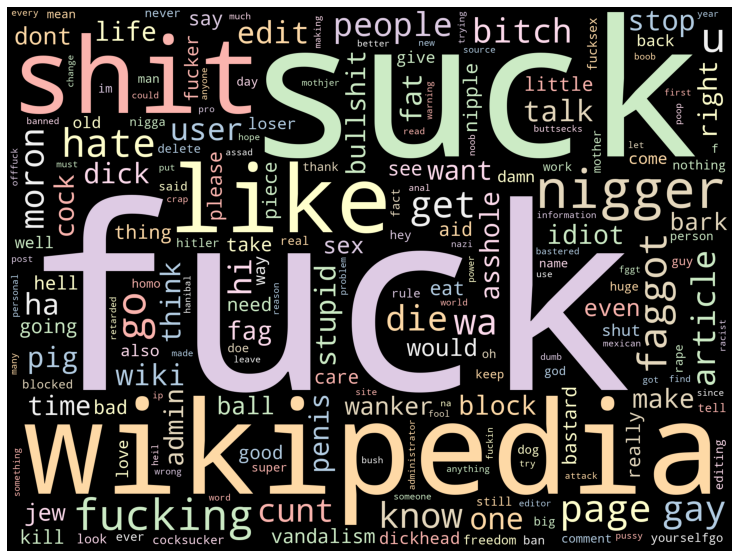

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud) 
plt.axis("off")

Хм.. выглядит очевидным.. но `wikipedia` тут зачем? Туда отправляют с глупыми вопросами?

<a name="c14"></a>
### LDA (Latent Dirichlet Allocation)

Латентное размещение Дирихле (LDA) – это тематическая модель, которая подразумевает, что каждый документ является коллекцией тематик, распределение которых соответствует распределению Дирихле

Построим для токсичных комментариев в `data_tfidf`:

In [ ]:
def words_features(sentence):
    new_sent = []
    for sent in sentence.split():
        if sent not in STOPWORDS:
            new_sent.append(sent)
    new_sent = " ".join(new_sent)
    return gensim.utils.simple_preprocess(new_sent, deacc=True)


data_words = data_tfidf['clear_text'].loc[data['toxic'] == 1].apply(words_features).values.tolist() #list(words_features(data))
id2word = corpora.Dictionary(data_words)
comments = data_words
corpus = [id2word.doc2bow(comment) for comment in comments]

Тренируем модель:

In [ ]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

Анализ:

In [ ]:
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [ ]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.062768 -0.014114       1        1  23.006041
0      0.091628  0.010433       2        1  15.358652
1      0.036590 -0.021017       3        1  12.863956
7      0.090543 -0.015966       4        1   9.828056
9     -0.288051 -0.005543       5        1   7.628949
5      0.061925 -0.029166       6        1   7.275613
2     -0.033115  0.241408       7        1   6.498346
6     -0.068949 -0.166825       8        1   6.410192
4      0.002795  0.028946       9        1   5.878183
3      0.043867 -0.028156      10        1   5.252011, topic_info=              Term          Freq         Total Category  logprob  loglift
139           fuck  10259.000000  10259.000000  Default  30.0000  30.0000
1498        nigger   6821.000000   6821.000000  Default  29.0000  29.0000
304            gay   3765.000000   3765.000000  Default  28.0000  28.0000
9749         super   2809.000000   2809.000000  Default  27.0000  27.0000
30052  criminalwar   1699.000000   1699.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
119      wikipedia     82.821300   3735.275255  Topic10  -5.5557  -0.8623
65             one     64.006443   1352.186799  Topic10  -5.8134  -0.1039
177           like     68.351720   3534.726797  Topic10  -5.7477  -0.9992
9          article     57.619356   1247.880800  Topic10  -5.9185  -0.1288
151           name     54.650282    554.842105  Topic10  -5.9714   0.6288

[711 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2738      10  0.917839     abnormal
4457       2  0.978203       actors
170        1  0.040562        admin
170        2  0.013367        admin
170        3  0.011984        admin
...      ...       ...          ...
1388      10  0.036483          yet
26163      4  0.941432         yooo
26163      5  0.048279         yooo
28404     10  0.995894  youbollocks
29434      8  0.998819   yourselfgo

[2519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 2, 8, 10, 6, 3, 7, 5, 4])

Результаты выглядят достаточно очевидными. <br>Интересные вещи можем увидеть в правом кластере

<a name="c15"></a>
## Получение признаков

<a name="c16"></a>
### TF-IDF

*TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. <br>Про TF-IDF подробнее [здесь](https://wiki.loginom.ru/articles/tf-idf.html)*

Т.к. подбор гиперпараметров будет осуществляться с помощью `GridSearchCV` с кросс-валидацией, трансформирование выборок на данном этапе приведет к утечке тестовых данных. <br><br>
Немного про утечку тестовых данных в кросс-валидации: чтобы не попадала информация о словах из тест. выборки в тренировочную, мы обучаем `TfidfVectorizer` на тренировочной выборке, после чего трансформируем тест. выборку. <br>**НО!** Наша ситуация в кросс-валидации (при 5 фолдах): тренировочная выборка делится на 4-тренировочных фолда и 1-тестовый фолд, при этом `TfidfVectorizer` обучался на 5-фолдах в сумме, поэтому информация из тест фолда попадает в тренировочные фолды <br><br>Будем использовать `Pipeline` из `scikit-learn`, куда дальше будем добавлять модели.

Выборки:

In [ ]:
features_train_tfidf, features_test_tfidf, target_train_tfidf, target_test_tfidf = train_test_split(data_tfidf['lemm_text'], data_tfidf['toxic'], test_size=0.25, random_state=RANDOM_STATE, stratify=data_tfidf['toxic'])

<a name="c17"></a>
### BERT

*Bidirectional Encoder Representations from Transformers ([BERT](https://en.wikipedia.org/wiki/BERT_(language_model))) - это нейронная сеть от Google, показавшая с большим отрывом state-of-the-art результаты на целом ряде задач*

Загрузим предобученную на токс. комментариях модель [unitary/toxic-bert](https://huggingface.co/unitary/toxic-bert) с [huggingface](https://huggingface.co):

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(BERT_MODEL)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN t

Класс для датасета:

In [ ]:
class CommentsDataset(torch.utils.data.Dataset):
    def __init__(self, features, max_len):
        """Загрузка токенизатора и получение padded, attention_maskv, max_len"""
        self.tokenizer = AutoTokenizer.from_pretrained(BERT_TOKEN)
        self.padded, self.attention_mask, self.max_len = self.tokenize(features, max_len)
        
    def __len__(self):
        return len(self.padded)
    
    def __getitem__(self, idx):
        """При вызове одновременно отправляем padded и attention_mask"""
        return (self.padded[idx], self.attention_mask[idx])

    def tokenize(self, features, max_len=0):
        """Токенизируем текст, сохраняем в self padded, attention_mask, max_len"""
        len_ = 0
        tokenized = features.apply(lambda x: self.tokenizer.encode(x, add_special_tokens=True, truncation=True))
        max_len = max(max(len(i) for i in tokenized.values), max_len)
        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        return padded, attention_mask, max_len

    def get_max_len(self):
        return self.max_len

Возьмем выборки:

In [ ]:
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(data_bert['clear_text'], data_bert['toxic'], test_size=0.25, stratify=data_bert['toxic'], random_state=RANDOM_STATE)

In [ ]:
print("Размер тренировочной выборки:", features_train_bert.shape[0])
print("Размер тестовой выборки:", features_test_bert.shape[0])

Размер тренировочной выборки: 4787
Размер тестовой выборки: 1596


Загрузим датасет:

In [ ]:
train_dataset = CommentsDataset(features_train_bert, 512)
test_dataset = CommentsDataset(features_test_bert, train_dataset.get_max_len())

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Получим эмбеддинги:

In [ ]:
def get_features(model, dataloader):
    """""""""
    Получение эмбеддингов. 
    Запускать на CPU не рекомендуется из-за длительности работы
    """""""""
    embeddings = [] 

    with tqdm(total=len(dataloader), file=sys.stdout) as prbar:
        for batch in dataloader:

            # Сформируем padded_batch и attention_mask_batch. 
            # Не забываем кидать на девайс (в нашем случае - это GPU).
            padded_batch = torch.LongTensor(batch[0]).to(device)
            attention_mask_batch = torch.LongTensor(batch[1]).to(device)
            
            # Отключим градиент, ведь мы не обучаем, а просто берём эмбеддинги.
            with torch.no_grad():
                model.to(device)
                batch_embeddings = model(padded_batch, attention_mask=attention_mask_batch)
            
            # Добавим соответствующий эмбеддинг. Для numpy кидаем на cpu
            embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

            # Чистим память
            del padded_batch
            del attention_mask_batch
            del batch_embeddings

            prbar.update(1)

    # Собираем мусор
    gc.collect()

    # Сформированные признаки
    return np.concatenate(embeddings)

In [ ]:
%%time
features_train_bert = get_features(model, train_dataloader)

100%|██████████| 75/75 [03:16<00:00,  2.62s/it]
CPU times: user 3min 10s, sys: 1.45 s, total: 3min 11s
Wall time: 3min 17s


In [ ]:
%%time
features_test_bert = get_features(model, test_dataloader)

100%|██████████| 25/25 [01:08<00:00,  2.73s/it]
CPU times: user 1min 8s, sys: 69.7 ms, total: 1min 8s
Wall time: 1min 8s


Эмбеддинги получены

<a name="c18"></a>
## Борьба с дисбалансом в таргете

*Данные называются несбалансированными (Imbalanced Data, дисбалансированы), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы»*

В качестве эксперимента, попробуем:
<br><br>
Для признаков `TF-IDF` уже в моделях сделать взвешивание классов (для интересующихся можно заменить на порог классификации, главное не на тестовой выборке)
<br><br>
Для эмбеддингов из `BERT` сделаем `upsampling` (методом [ADASYN](https://ieeexplore.ieee.org/document/4633969)) при построении `Pipeline`. 

<b>Почему нельзя сразу сделать upsampling на тренировочной выборке?</b> - тогда наша тренировочная выборка будет увеличена для уравновешивания классов, а это значит, что при подборе гиперпараметров с кросс-валидацией тестовый фолд в кросс-валидации будет со сбалансированными классами. Тест. выборка должна сохранять оригинальное распределение в таргете (т.е. дисбаланс)

<a name="c19"></a>

## Вывод:

Перед обучением, мы выполнили:
  <ul>
    <li>Анализ признаков в датасете. Нашли дисбаланс в таргете, множество неинформативных символов, которые удалили из текста.</li>
    <li>Взяли выборку для более быстрого процесса предобработки текста, лемматизации и обучения моделей</li>
    <li>Очистили текст для BERT, очистили и лемматизировали текст для TfidfVectorizer, везде попробовали исправить опечатки</li>
    <li>Дополнительно посмотрели облако слов</li>
    <li>И LDA</li>
    <li>Загрузили модель и токенизатор BERT, получили эмбеддинги, из них сделали признаки. Для получения TF-IDF признаков создали Pipeline</li>
    <li>Для борьбы с дисбалансом выбрали upsampling эмбеддингов. Для признаков TF-IDF выбрали взвешивание классов уже в моделях и подбор порога классификации</li>
  </ul>

Приступаем к обучению

<a name="c20"></a>

# Обучение моделей

Для обучения были выбраны:
    <ul>
      <li>LogisticRegression</li>
      <li>Linear model with stochastic gradient descent (SGDClassifier)</li>
      <li>LGBMClassifier</li>
    </ul>

Две лучшие модели выберем отдельно на `TF-IDF` и `BERT` признаках по лучшей `F1-мере` на `кросс-валидации`. <br>Везде за baseline у нас будет `DummyClassifier`.<br>Две лучшие модели финально проверим на тестовой выборке<br><br>

---

Результаты будем хранить в pd.DataFrame `result`

In [ ]:
# 'Model_Name': [features, f1_score, time_fit, time_predict]

col_names = [METRIC, "Время обучения", "Время предсказания"]

result = pd.DataFrame(columns=col_names)
display(result)

,f1,Время обучения,Время предсказания


Полезные функции:

In [ ]:
col_names = [METRIC, "Время обучения", "Время предсказания"]


def cross_val_model_result(model, features_train, target_train, name_model):
    """Кросс-валидация c временем предсказания и обучения"""
    global result
    result_cv = cross_validate(model, features_train, target_train, scoring=METRIC, cv=CV, n_jobs=N_CPU, verbose=VERBOSE)
    score = result_cv['test_score']
    print(f"{METRIC} на кросс-валидации: {score}")
    print(f"{METRIC} mean: {score.mean()}")
    result_list = [score.mean(), result_cv['fit_time'].mean(), result_cv['score_time'].mean()]
    result = pd.concat([result, pd.DataFrame([result_list], 
                                columns=col_names, index=[name_model]),
                        ])


def GSCV(model, param_grid, features_train, target_train, name_model):
    """GridSearchCV short"""
    global result
    model = GridSearchCV(model, param_grid=param_grid, scoring=METRIC, cv=CV, n_jobs=N_CPU, verbose=VERBOSE)
    model.fit(features_train, target_train)
    print("Лучшие гиперпараметры:", model.best_params_)
    cv_res = model.cv_results_
    print(f"Лучший {METRIC}: {model.best_score_}")
    result_list = [model.best_score_, cv_res['mean_fit_time'].mean(), cv_res['mean_score_time'].mean()]
    result = pd.concat([result, pd.DataFrame([result_list], 
                                columns=col_names, index=[name_model]),
                        ])

    
model_features_tfidf = Pipeline([('tf_idf', TfidfVectorizer(stop_words=STOPWORDS))])

# model_features_up = make_pipeline(ADASYN(random_state=RANDOM_STATE))
# Возьмем более очев. способ:
model_features_up = make_pipeline(RandomOverSampler(random_state=RANDOM_STATE))

<a name="c21"></a>
## На признаках TF-IDF

### DummyClassifier

In [ ]:
# Клонируем Pipeline
dummy_tfidf = clone(model_features_tfidf)

# Добавляем модель
dc = DummyClassifier(random_state=RANDOM_STATE)
dummy_tfidf.steps.append(['dummy', dc])

Посмотрим метрику и запишем результаты

In [ ]:
%%time

cross_val_model_result(dummy_tfidf, features_train_tfidf, target_train_tfidf, 'Dummy_TF_IDF')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.6s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished
f1 на кросс-валидации: [0. 0. 0. 0. 0.]
f1 mean: 0.0
CPU times: user 817 ms, sys: 318 ms, total: 1.14 s
Wall time: 20.9 s


In [ ]:
result

,f1,Время обучения,Время предсказания
Dummy_TF_IDF,0.0,5.463566,1.249098


Отлично!) <br>Отталкиваемся от этой метрики для всех моделей, обученных на TF-IDF признаках

### LogisticRegression

Начнём обучение с классической модели машинного обучения -<b> лог. регрессии</b>. <br>Установим `solver="sag"` (Stochastic Average Gradient).<br>
Подберём регуляризацию для модели и запишем результаты в `result`.<br> Также добавим в параметры взвешивание классов.

In [ ]:
# Клонируем Pipeline
log_tfidf = clone(model_features_tfidf)

# Добавляем модель
log_reg =  LogisticRegression(random_state=RANDOM_STATE, solver='sag')
log_tfidf.steps.append(['logistic', log_reg])

In [ ]:
%%time

# Параметры
param_grid = {'logistic__C': [1, 3], 'logistic__class_weight': ['balanced']}

# Подбор гиперпараметров
GSCV(log_tfidf, param_grid, features_train_tfidf, target_train_tfidf, 'Log_TF_IDF')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучшие гиперпараметры: {'logistic__C': 3, 'logistic__class_weight': 'balanced'}
Лучший f1: 0.7413700975418517
CPU times: user 14.2 s, sys: 405 ms, total: 14.6 s
Wall time: 1min 28s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
result

,f1,Время обучения,Время предсказания
Dummy_TF_IDF,0.00000,5.463566,1.249098
Log_TF_IDF,0.74137,12.930991,1.307346


Порог пройден! <br>Насколько этот результат применим в реальной работе должен будет выяснить бизнес

### Linear model with stochastic gradient descent (SGDClassifier)

Попробуем SGDClassifier с взвешиванием классов, подбором `alpha`

In [ ]:
# Клонируем Pipeline
sgd_tfidf = clone(model_features_tfidf)

# Добавляем модель
sgd =  SGDClassifier(class_weight='balanced', random_state=RANDOM_STATE)
sgd_tfidf.steps.append(['sgd', sgd])

In [ ]:
%%time

# Параметры
param_grid = {'sgd__alpha': np.arange(0.001, 0.1, 0.05)}

# Подбор гиперпараметров
GSCV(sgd_tfidf, param_grid, features_train_tfidf, target_train_tfidf, 'SGD_TF_IDF')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучшие гиперпараметры: {'sgd__alpha': 0.001}
Лучший f1: 0.7055284958689036
CPU times: user 6.32 s, sys: 267 ms, total: 6.59 s
Wall time: 44.8 s


In [ ]:
result

,f1,Время обучения,Время предсказания
Dummy_TF_IDF,0.000000,5.463566,1.249098
Log_TF_IDF,0.741370,12.930991,1.307346
SGD_TF_IDF,0.705528,6.329179,1.403886


### LightGBM

Поработаем с ` Light Gradient Boosting Machine` на `GPU` с подбором гиперпараметров с помощью [optuna](https://optuna.readthedocs.io/en/stable/). <br>Внутри `optuna` уже есть `LGBM`, но мы рассмотрим общий случай работы:

Зададим функцию с параметрами и приведением к нужным типам:

In [ ]:
def search_lgbm_cv(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, 200),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "max_depth" : trial.suggest_int("max_depth", 5, 20, 5),
        'device': 'gpu',
        'class_weight': 'balanced'
    }

    lgb_tfidf = clone(model_features_tfidf)
    model = lgb.LGBMClassifier(**param, random_state=RANDOM_STATE)
    lgb_tfidf.steps.append(['lgb', model])
    score = cross_validate(
                          lgb_tfidf, 
                          features_train_tfidf,
                          target_train_tfidf,
                          scoring=METRIC,
                          cv=3,
                          n_jobs=N_CPU,
                          verbose=VERBOSE
                          )['test_score'].mean()
    return score

Не будем тратить много времени на подбор, поэтому ограничим его. <br>Пусть будет 10 минут. Запуск подбора:

In [ ]:
%%time

study = optuna.create_study(direction="maximize")
study.optimize(search_lgbm_cv, timeout=(10*60), n_trials=100)

[I 2022-08-05 13:44:10,056] A new study created in memory with name: no-name-f508e193-2a7e-4a93-b10a-235ca7973526


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min


[I 2022-08-05 13:46:12,522] Trial 0 finished with value: 0.6829175051345674 and parameters: {'n_estimators': 100, 'boosting_type': 'dart', 'max_depth': 15}. Best is trial 0 with value: 0.6829175051345674.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min


[I 2022-08-05 13:48:36,810] Trial 1 finished with value: 0.6814552632765434 and parameters: {'n_estimators': 300, 'boosting_type': 'dart', 'max_depth': 5}. Best is trial 0 with value: 0.6829175051345674.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min


[I 2022-08-05 13:52:36,972] Trial 2 finished with value: 0.7315652955764831 and parameters: {'n_estimators': 300, 'boosting_type': 'gbdt', 'max_depth': 15}. Best is trial 2 with value: 0.7315652955764831.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.3s


[I 2022-08-05 13:54:11,278] Trial 3 finished with value: 0.6747683019605836 and parameters: {'n_estimators': 100, 'boosting_type': 'dart', 'max_depth': 10}. Best is trial 2 with value: 0.7315652955764831.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished
CPU times: user 4.85 s, sys: 719 ms, total: 5.57 s
Wall time: 10min 1s


In [ ]:
study.best_params

{'boosting_type': 'gbdt', 'max_depth': 15, 'n_estimators': 300}

In [ ]:
study.best_value

0.7315652955764831

Посмотрим результаты на кросс-валидации:

In [ ]:
# Клонируем Pipeline
lgbm_tfidf = clone(model_features_tfidf)

# Добавляем модель
lgbm =  lgb.LGBMClassifier(**study.best_params)
lgbm_tfidf.steps.append(['lgbm', lgbm])

In [ ]:
%%time

cross_val_model_result(lgbm_tfidf, features_train_tfidf, target_train_tfidf, 'LGBM_TF_IDF')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished
f1 на кросс-валидации: [0.73237944 0.74547837 0.73453199 0.74469756 0.73953121]
f1 mean: 0.7393237160817497
CPU times: user 3.01 s, sys: 369 ms, total: 3.38 s
Wall time: 7min 30s


In [ ]:
# Удаляем лишнее

del lgbm_tfidf
del sgd_tfidf
del log_tfidf
del dummy_tfidf
gc.collect()

865

<a name="c23"></a>
### Результат:

In [ ]:
result.sort_values(by=METRIC, ascending=False)

,f1,Время обучения,Время предсказания
Log_TF_IDF,0.741370,12.930991,1.307346
LGBM_TF_IDF,0.739324,154.058838,4.519685
SGD_TF_IDF,0.705528,6.329179,1.403886
Dummy_TF_IDF,0.000000,5.463566,1.249098


Лучший результат по всем показателям выдала модель `LogisticRegression`, которая сочетает в себе не только высокие показатели по метрике, но и по скорости обучения и предсказания.
<br><br>
Spoiler: `LightGBM` при правильном подборе покажет метрику выше >0.77, но на это уйдет $n$-ое (${n \to +\infty}$) количество времени и нервов<br>

<a name="c24"></a>
## На эмбеддингах BERT

Время поработать с `BERT`

### DummyClassifier

Процедуры те же:

In [ ]:
# Клонируем Pipeline
dummy_bert = clone(model_features_up)

# Добавляем модель
dc = DummyClassifier(random_state=RANDOM_STATE)
dummy_bert.steps.append(['dummy', dc])

In [ ]:
%%time

cross_val_model_result(dummy_bert, features_train_bert, target_train_bert, 'Dummy_BERT')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
f1 на кросс-валидации: [0. 0. 0. 0. 0.]
f1 mean: 0.0
CPU times: user 208 ms, sys: 299 ms, total: 507 ms
Wall time: 7.82 s


In [ ]:
result

,f1,Время обучения,Время предсказания
Dummy_TF_IDF,0.000000,5.463566,1.249098
Log_TF_IDF,0.741370,12.930991,1.307346
SGD_TF_IDF,0.705528,6.329179,1.403886
LGBM_TF_IDF,0.739324,154.058838,4.519685
Dummy_BERT,0.000000,2.032240,0.002139


Результат по метрике равен `Dummy_TF_IDF`

### LogisticRegression

In [ ]:
# Клонируем Pipeline
log_bert = clone(model_features_up)

# Добавляем модель
log_reg =  LogisticRegression(random_state=RANDOM_STATE)
log_bert.steps.append(['logistic', log_reg])

In [ ]:
%%time

# Параметры
param_grid = {'logistic__C': [1, 3]}

# Подбор гиперпараметров
GSCV(log_bert, param_grid, features_train_bert, target_train_bert, 'Log_BERT')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучшие гиперпараметры: {'logistic__C': 1}
Лучший f1: 0.8897584737122279
CPU times: user 1min 16s, sys: 3.14 s, total: 1min 19s
Wall time: 5min 54s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
result

,f1,Время обучения,Время предсказания
Dummy_TF_IDF,0.000000,5.463566,1.249098
Log_TF_IDF,0.741370,12.930991,1.307346
SGD_TF_IDF,0.705528,6.329179,1.403886
LGBM_TF_IDF,0.739324,154.058838,4.519685
Dummy_BERT,0.000000,2.032240,0.002139
Log_BERT,0.889758,61.689363,0.321736


Хороший результат

### Linear model with stochastic gradient descent (SGDClassifier)

In [ ]:
# Клонируем Pipeline
sgd_bert = clone(model_features_up)

# Добавляем модель
sgd =  SGDClassifier(random_state=RANDOM_STATE)
sgd_bert.steps.append(['sgd', sgd])

In [ ]:
%%time

# Параметры
param_grid = {'sgd__alpha': np.arange(0.001, 0.1, 0.05)}

# Подбор гиперпараметров
GSCV(sgd_bert, param_grid, features_train_bert, target_train_bert, 'SGD_BERT')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Лучшие гиперпараметры: {'sgd__alpha': 0.001}
Лучший f1: 0.8748003508032542
CPU times: user 35.6 s, sys: 2.15 s, total: 37.8 s
Wall time: 2min 21s


In [ ]:
# Удаляем лишнее

del sgd_bert
del log_bert
del dummy_bert
gc.collect()

497

In [ ]:
result

,f1,Время обучения,Время предсказания
Dummy_TF_IDF,0.000000,5.463566,1.249098
Log_TF_IDF,0.741370,12.930991,1.307346
SGD_TF_IDF,0.705528,6.329179,1.403886
LGBM_TF_IDF,0.739324,154.058838,4.519685
Dummy_BERT,0.000000,2.032240,0.002139
Log_BERT,0.889758,61.689363,0.321736
SGD_BERT,0.874800,19.992728,0.180608


<a name="c25"></a>
### Результат:

In [ ]:
result.sort_values(by=METRIC, ascending=False)

,f1,Время обучения,Время предсказания
Log_BERT,0.889758,61.689363,0.321736
SGD_BERT,0.874800,19.992728,0.180608
Log_TF_IDF,0.741370,12.930991,1.307346
LGBM_TF_IDF,0.739324,154.058838,4.519685
SGD_TF_IDF,0.705528,6.329179,1.403886
Dummy_TF_IDF,0.000000,5.463566,1.249098
Dummy_BERT,0.000000,2.032240,0.002139


Лучшая модель по метрике <b>(x2)</b>: `SGD_BERT`<br><br>Spoiler: LightGBM пропущен, но при правильном подборе покажет метрику выше, но на это уйдет  𝑛 -ое ( 𝑛→+∞ ) количество времени и нервов 

<a name="c26"></a>
## Тестирование:

Обучим `Log_TF_IDF` и посмотрим результаты на тестовой выборке:

In [ ]:
# Клонируем Pipeline
log_tfidf = clone(model_features_tfidf)

# Добавляем модель
log_reg =  LogisticRegression(random_state=RANDOM_STATE, solver='sag', C=1)
log_tfidf.steps.append(['logistic', log_reg])

log_tfidf.fit(features_train_tfidf, target_train_tfidf)
print(f1_score(log_tfidf.predict(features_test_tfidf), target_test_tfidf))

0.726943346508564


Теперь `SGD_BERT`

In [ ]:
# Клонируем Pipeline
sgd_bert = clone(model_features_up)

# Добавляем модель
sgd =  SGDClassifier(random_state=RANDOM_STATE, alpha=0.001)
sgd_bert.steps.append(['sgd', sgd])

sgd_bert.fit(features_train_bert, target_train_bert)
print(f1_score(sgd_bert.predict(features_test_bert), target_test_bert))

0.8706624605678233


Отличный результат и на тестовой выборке.

Построим ROC-кривую для `LogisticRegression`:

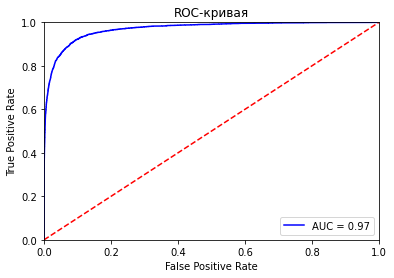

In [ ]:
probs = log_tfidf.predict_proba(features_test_tfidf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(target_test_tfidf, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC-кривая')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
print(metrics.classification_report(target_test_tfidf, log_tfidf.predict(features_test_tfidf)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     34627
           1       0.92      0.60      0.73      3670

    accuracy                           0.96     38297
   macro avg       0.94      0.80      0.85     38297
weighted avg       0.96      0.96      0.95     38297



Очевидные проблемы с полнотой, пусть и получаются весьма точные результаты. 

<a name="c27"></a>
## Вывод:

В ходе обучения мы:
  <ul>
    <li>Создали отдельные пайплайны для получения признаков `TF-IDF` с помощью `TfidfVectorizer` и `upsampling` для эмбеддингов `BERT`</li>
    <li>Написали удобные функции для подбора гиперпараметров, инициализировали табличку для записи результатов</li>
    <li>Подобрали для выбранных моделей гиперпараметры, сравнили их по скорости обучения, предсказания, `F1-мере`</li>
    <li>Лучшие модели на признаках `TF-IDF` и эмбеддингах `BERT` финально протестировали на тест. выборке</li>
    <li>Все две финальные модели показали результаты лучше, чем `DummyClassifier`</li>
    
    
  </ul>


<a name="c28"></a>
# Немного про CatBoost и текстовые признаки

CatBoost умеет работать с текстом через параметр `text_features`. <br>Попробуем дать очищенный текст:

In [ ]:
data['clear_text'] = data['comment_text'].apply(clear_text)

features_train, features_test, target_train, target_test = train_test_split(data['clear_text'], data['toxic'], test_size=0.25, random_state=RANDOM_STATE, stratify=data['toxic'])

Сразу же сделаем взвешивание классов:

In [ ]:
catboost_model = CatBoostClassifier(random_state=RANDOM_STATE, class_weights=[0.9, 0.1]) #task_type='GPU')

In [ ]:
%%time
catboost_model.fit(pd.DataFrame(features_train), target_train, text_features=['clear_text'], verbose=100)

Learning rate set to 0.079478
0:	learn: 0.5345007	total: 369ms	remaining: 6m 8s
100:	learn: 0.0299048	total: 33.5s	remaining: 4m 57s
200:	learn: 0.0278235	total: 1m 6s	remaining: 4m 25s
300:	learn: 0.0268716	total: 1m 38s	remaining: 3m 49s
400:	learn: 0.0261827	total: 2m 11s	remaining: 3m 15s
500:	learn: 0.0258203	total: 2m 42s	remaining: 2m 41s
600:	learn: 0.0253757	total: 3m 13s	remaining: 2m 8s
700:	learn: 0.0249769	total: 3m 45s	remaining: 1m 36s
800:	learn: 0.0247055	total: 4m 17s	remaining: 1m 3s
900:	learn: 0.0244469	total: 4m 48s	remaining: 31.7s
999:	learn: 0.0241623	total: 5m 20s	remaining: 0us
CPU times: user 9min 33s, sys: 58.8 s, total: 10min 32s
Wall time: 5min 27s


In [ ]:
target_predict = catboost_model.predict(pd.DataFrame(features_test))

f1_score(target_test, target_predict)

0.6538860103626943

Быстро, минималистично, больше нуля

<a name="c29"></a>
# Финальный вывод

В ходе работы мы познакомились с:
  <ul>
    <li>Анализом текста</li>
    <li>Способами предобработать текст</li>
    <li>Методами получения из текста признаков для дальнейшей работы моделей МО (`TF-IDF` и эмбеддинги `BERT`)</li>
    <li>Вариантами работы с сильным дисбалансом в таргете (`upsampling` и `взвешивание классов`)</li>
    <li>Подбором гиперпараметров, обучением и сравнением моделей:
    <ul><li>`DummyClassifier`</li>
        <li>`LogisticRegression`</li>
        <li>`SGDClassifier`</li>
        <li>`LGBMClassifier`</li></ul>
    На признаках `TF-IDF` и `BERT`-эмбеддингах</li>
    <li>Отдельно обучили `CatBoost` с использованием внутренних методов работы с текстом</li>
  </ul>


Что можно ещё посмотреть:
    <ul>
      <li>Другие предобученные `BERT` модели</li>
      <li>Word2Vec (не только в процессе построения моделей МО, но, например, для замены слов на синонимы. В утопийной гипотизе все плохие слова поменяются на `toxic`, а задача классификации станет тривиальной)</li>
      <li>Увеличить везде кол-ва гиперпараметров для перебора</li>
      <li>Есть не только `train.csv`. Другие файлы бывает полезно изучить)</li>
      <li>Погрузиться в анализ текстов: буквенные регистры, повторяющиеся буквы (`FUUUUUUUCCCCC`) и т.д.</li>
      <li>Попробовать поискать ключевые слова или использовать суммаризаторы</li>
      <li>За baseline взять наивный байесовский классификатор (правило независимости идёт в плюс)</li>
    </ul>

<a name="c30"></a>
# Bonus: Tensorflow/Keras (Bidirectional LSTM)

Бонусный раздел, где пробуется `Bidirectional LSTM` (Bidirectional long-short term memory) для текстовой классификации.
<br><br>
Spoiler: **0 комментариев к коду**

Импорты:

In [ ]:
import os
import re

import keras
from keras import layers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras import backend as tfK  
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np


GPU check:

In [ ]:
tfK._get_available_gpus()

['/device:GPU:0']

Загрузка датасета:

In [ ]:
!mkdir datasets
!unzip jigsaw-toxic-comment-classification-challenge.zip -d datasets
!dir datasets
!unzip datasets/train.csv.zip -d datasets

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: datasets/sample_submission.csv.zip  
  inflating: datasets/test.csv.zip   
  inflating: datasets/test_labels.csv.zip  
  inflating: datasets/train.csv.zip  
sample_submission.csv.zip  test.csv.zip  test_labels.csv.zip  train.csv.zip
Archive:  datasets/train.csv.zip
  inflating: datasets/train.csv      


In [ ]:
path1 = "../input/traint/train.csv"
path2 = "/content/datasets/train.csv"

if os.path.exists(path1):
    data = pd.read_csv(path1)
elif os.path.exists(path2):
    data = pd.read_csv(path2)
else:
    print("We have a problem")

Приводим данные к нужному формату:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(data['comment_text'], data['toxic'], test_size=0.25)

In [ ]:
max_words = 750
max_len = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(features_train)
sequences = tokenizer.texts_to_sequences(features_train)
train_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
def BiLSTM(emd_out: int) -> keras.Sequential:
    """Сетка Bidirectional LSTM"""

    model = keras.Sequential(
        [
            layers.Input(name='input', shape=[max_len]),
            layers.Embedding(max_words, emd_out, input_length=max_len),
            layers.Bidirectional(layers.LSTM(128), merge_mode='mul'),
            layers.Dense(64, name='FC1'),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            layers.Dropout(0.5),
            layers.Dense(16, name='FC2'),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            layers.Dropout(0.5),
            layers.Dense(1, name='out'),
            layers.Activation('sigmoid'),
        ]
    )

    return model



def f1_m(y_true, y_pred):
    """Метрика"""

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())

    return 2 * ((precision * recall) / (precision+recall + K.epsilon()))


In [ ]:
model = BiLSTM(256)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])

In [ ]:
reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [ ]:
model.fit(train_matrix, target_train, batch_size=256, epochs=5,
          validation_split=0.2, callbacks=[reducelr])

Epoch 1/5
374/374 [==============================] - 111s 288ms/step - loss: 0.2394 - f1_m: 0.4371 - val_loss: 0.1558 - val_f1_m: 0.6130 - lr: 0.0010
Epoch 2/5
374/374 [==============================] - 107s 285ms/step - loss: 0.1730 - f1_m: 0.6153 - val_loss: 0.1555 - val_f1_m: 0.6391 - lr: 0.0010
Epoch 3/5
374/374 [==============================] - 107s 287ms/step - loss: 0.1732 - f1_m: 0.5741 - val_loss: 0.1562 - val_f1_m: 0.6371 - lr: 0.0010
Epoch 4/5
374/374 [==============================] - 108s 288ms/step - loss: 0.1593 - f1_m: 0.6322 - val_loss: 0.1545 - val_f1_m: 0.6512 - lr: 0.0010
Epoch 5/5
374/374 [==============================] - 109s 293ms/step - loss: 0.1531 - f1_m: 0.6479 - val_loss: 0.1539 - val_f1_m: 0.6515 - lr: 0.0010


In [ ]:
sequences = tokenizer.texts_to_sequences(features_test)
test_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
y_pred = np.around(model.predict(test_matrix))

In [ ]:
f1_score(y_pred, target_test)

0.6279727257608515

Больше нуля 👼